kmeans.ipynb

Discussion: This Jupyter notebook investigates clustering discrete data with kmeans.

Licensing: This code is distributed under the GNU LGPL license.
    
Modified: 28 October 2016

Author: John Burkardt, Lukas Bystricky

In [4]:
# Import necessary libraries and set plot option
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.spatial as spatial

# K Means #

In this module we will investigate the problem of arranging N items of
M-dimensional data into K groups or "clusters", in such a way that the 
items in each group are close.

Each group will be associated with a special value called the "mean".
We may expect this value to be the centroid of the group values, but
while we are computing, sometimes this will not quite be the case.

Our examples will use M=2 dimensions, but the method works for any M.

We need to understand 
* how the "energy" of a group measures closeness;
* the importance of the centroid/mean/generator, 
* how to randomly assign a data item to a cluster, 
* how to compute the energy of a cluster and of the collection of clusters, 
* how to assign items to the nearest generator or mean, 
* how to update the means, 
* how to carry out an iteration that repeatedly reduces the clustering energy.

# Point energy, cluster energy, and the centroid #

Suppose we have a set of points G whose typical point is x.
We will call G a "group" or a "cluster", and the idea is that
all the points in G ought to be close or tightly clustered.

In order to evaluate how tightly clustered a set of points is, we 
use the idea of "energy".  To define the energy, we have to include
a special value we might call the base point, or mean, or center, or generator.
Let's call it "m".  

The point energy of x (with respect to m ) is
  e(x,m) = ||x - m||^2
that is, just the square of the Euclidean distance.
Obviously, for a given x, e(x,m) is minimized by setting m=x (not exciting!)

Since x is part of a set G, we can now also assign a cluster energy to G,
  e(G,m) = sum (all x in g ) e(x,m)
Now we said that m could be any point at all.  An interesting question 
becomes: if we can choose any value for m, is there a value that minimizes
the cluster energy.  The answer to this is that we should choose m to be
the average of the x values.  (You can show this by differentiating the
expression for e(G,m) with respect to m).

We would like to make a small test to verify that, for a given set of points x
in a cluster G, the value of e(G,m) is minimized by the average (which we
might also call the centroid or mean.)


In [5]:
## Minimizing the energy of a cluster
#
#  Create a 10x2 array G containing 10 random 2D points in the unit square.
#
#  Define a function cluster_energy ( G, m ) which returns the cluster
#  energy of the points in G relative to the point m.
#
#  Define
#    m1 = (0,0)
#    m2 = (0.2,0.7)
#    m3 = the first point in G = G[0,:]
#    m4 = average of points in G
#
#  and evaluate the cluster energies e(G,m1), e(G,m2), e(G,m3), e(G,m4).
#
#  You should see that e(G,m4) is lower than the other values, and indeed,
#  it will be lower than the cluster energy for any other choice of m.
#
n = 10
G = np.random.rand ( n, 2 )
print ( G )

def cluster_energy ( G, m ):
  energy = 0.0
  rows = G.shape[0]
  for row in range ( 0, rows ):
    energy = energy + ( np.linalg.norm ( G[row,:] - m[:] ) ) ** 2
  return energy

m1 = np.array ( [ 0.0, 0.0 ] )
m2 = np.array ( [ 0.2, 0.7 ] )
m3 = G[0,:]
m4 = np.sum ( G, axis = 0 ) / float ( n )

print ( m1, cluster_energy ( G, m1 ) )
print ( m2, cluster_energy ( G, m2 ) )
print ( m3, cluster_energy ( G, m3 ) )
print ( m4, cluster_energy ( G, m4 ) )

[[ 0.62022095  0.25780003]
 [ 0.85224345  0.32585312]
 [ 0.18210333  0.57784647]
 [ 0.35746139  0.59488945]
 [ 0.49054516  0.21448136]
 [ 0.47745961  0.9499567 ]
 [ 0.22000546  0.11850909]
 [ 0.3525047   0.56682692]
 [ 0.64253934  0.47827504]
 [ 0.00637021  0.93105693]]
(array([ 0.,  0.]), 5.5659070553836907)
(array([ 0.2,  0.7]), 2.1636324489619718)
(array([ 0.62022095,  0.25780003]), 2.2796071996895089)
(array([ 0.42014536,  0.50154951]), 1.2851666876061194)


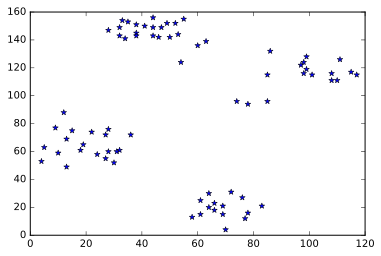

In [6]:
# Reading data #
#
#  For our first experiments, the items we are going to try to cluster 
#  will be the (x,y) coordinates of 75 points.
#
#  The data values are stored in the file "ruspini.txt".
#
#  Download the data from the web page:
#
#    http://people.sc.fsu.edu/~jburkardt/classes/urop_2016/ruspini.txt
#
#  Read the data from the file.
#
#  Rewrite your work so it is a function:
#
#    def ruspini_data ( ):
#      ***
#      return xy
#
def ruspini_data ( ):
    
  xy = np.zeros ( [ 75, 2 ] )
  
  input = open ( 'ruspini.txt', 'r' )
  
  i = 0
  for line in input:
    j = 0
    for word in line.strip().split():
      xy[i,j] = float ( word )
      j = j + 1
    i = i + 1

  input.close ( )

  return xy
#
#  Use the function.
#
#  Plot the data, and see that it naturally separates into
#  a certain number of clusters.
#
xy = ruspini_data ( )
plt.plot ( xy[:,0], xy[:,1], 'b*' )

In [9]:
# Initial Cluster Assignment
#
#  If xy represents our data values, then for each xy[i],
#  we need an array c so that c[i] records the cluster 
#  that the points belongs to.
#
#  To start the K-means algorithm, we might as well just
#  randomly assign points to clusters.
#
#  We don't want any cluster to be empty.  So the easiest
#  thing to do is assign point 0 to cluster 0, point 1 to
#  cluster 1, ..., point K-1 to cluster K-1, and then
#  wrap around to point K is sent to cluster 0, point K+1
#  to cluster 1 and so on, which is essentially using the
#  mod function.
#
#  The other simple choice is to call NUMPY's random.randint()
#  function to return a random list of integers between 0
#  and k-1.  The advantage of this choice is that we will
#  get a different initial configuration every time we call.
#
#  Write functions:
#
#    def initial_clusters_mod ( n, k ):
#      ***
#      return c
#
#    def initial_clusters_random ( n, k ):
#      ***
#      return c
#
#  For the case N = 20 and K = 3, call each function twice, 
#  print the results, and show that the second function gives
#  different results each time.
#
def initial_clusters_mod ( n, k ):
  c = np.zeros ( n, dtype = np.int32 )
  for i in range ( 0, n ):
    c[i] = ( i % k )
  return c

def initial_clusters_random ( n, k ):
  c = np.random.randint ( 0, k, n )
  return c

xy = ruspini_data ( )
n = 75
k = 3

c1 = initial_clusters_mod ( n, k )
c2 = initial_clusters_mod ( n, k )
c3 = initial_clusters_random ( n, k )
c4 = initial_clusters_random ( n, k )

print ( '' )
print ( '   I  MOD1  MOD2 RANDOM1 RANDOM2:' )
print ( '' )
for i in range ( 0, n ):
  print ( '%4d  %4d  %4d  %4d  %4d' % ( i, c1[i], c2[i], c3[i],c4[i] ) )  



   I  MOD1  MOD2 RANDOM1 RANDOM2:

   0     0     0     2     0
   1     1     1     2     2
   2     2     2     0     2
   3     0     0     1     0
   4     1     1     0     1
   5     2     2     1     0
   6     0     0     2     2
   7     1     1     1     2
   8     2     2     1     1
   9     0     0     1     1
  10     1     1     2     0
  11     2     2     0     0
  12     0     0     2     0
  13     1     1     1     2
  14     2     2     1     1
  15     0     0     1     1
  16     1     1     1     0
  17     2     2     2     1
  18     0     0     0     0
  19     1     1     2     0
  20     2     2     1     2
  21     0     0     0     0
  22     1     1     1     2
  23     2     2     2     1
  24     0     0     2     1
  25     1     1     0     2
  26     2     2     0     1
  27     0     0     2     1
  28     1     1     1     0
  29     2     2     0     2
  30     0     0     0     0
  31     1     1     2     2
  32     2     2     1     1
  33   

In [19]:
# Cluster statistics #
#
#  Assuming we have K clusters, and that the vector J=C[I] stores the
#  cluster J to which point X[I] is assigned, we want to compute the 
#  following arrays for each cluster J
#
#  POP(J) = number of items in the cluster
#  MN(J,2) = the mean or average of the items in the cluster
#  E(J) = energy of the cluster
#
#  Use K = 3, and N = 30, and the random cluster assigment function
#  initial_clusters_random(), compute these quantities.
#
#  When you like what you have written, rewrite it as a function:
#
#  def cluster_stats ( n, xy, c, k ):
#    ***
#    return pop, mn, e
#
#  so we can update these statistics as we change the cluster assignments.
#
def cluster_stats ( n, xy, c, k ):

  pop = np.zeros ( k, dtype = np.int32 )
  dim = xy.shape[1]
  mn = np.zeros ( [ k, dim ] )
  e = np.zeros ( k )

  for i in range ( 0, n ):
    j = c[i]
    pop[j] = pop[j] + 1
    mn[j,:] = mn[j,:] + xy[i,:]

  for j in range ( 0, k ):
    mn[j,:] = mn[j,:] / float ( max ( pop[j], 1 ) )

  for i in range ( 0, n ):
    j = c[i]
    e[j] = e[j] + ( np.linalg.norm ( xy[i,:] - mn[j,:] ) ) ** 2

  return pop, mn, e
#
#  Use the function.
#
n = 75
k = 3
xy = ruspini_data ( )
c = initial_clusters_random ( n, k )
pop, mn, e = cluster_stats ( n, xy, c, k )

print ( '' )
print ( '  Cluster   Pop  Energy')
print ( '')

for j in range ( 0, k ):
  print ( '      %3d  %4d  %f' % ( j, pop[j], e[j] ) )

print ( '' )
print ( '  Total    %4d                        %f' % ( np.sum ( pop ), np.sum ( e ) ) )




  Cluster   Pop  Energy

        0    27  90289.037037
        1    23  63374.782609
        2    25  85914.320000

  Total      75                        239578.139646


In [12]:
#  Find Nearest Cluster
#
#  We want the data to be clustered, and we use the energy to measure this.  
#  Energy depends on how close you are to the mean of your cluster.
#  Suppose a data item is in the "wrong" cluster.  We will take this
#  to mean that the data item is closer to the mean of some other cluster
#  than it is to the mean of its current cluster.  What would happen if
#  we transferred that item to the cluster of the closer mean?  The energy
#  in the old cluster would go down, and the energy in the new cluster would
#  go up.  But the energy of the old cluster will go down more than the 
#  energy of the new cluster will go up (because they are based on the distance
#  to the cluster mean)  That means our total energy will go down, and that's good.
# 
#  Write a function which looks like this:
#
#    def nearest_cluster ( n, i, xy, k, mn ):
#      *****
#      return j2
#
#  which has as input and output:
#    N, the number of data items;
#    I, the data item that we are interested in;
#    XY, the list of all data item coordinates;
#    K, the number of clusters;
#    MN, the cluster means;
#    J2, the index of the cluster mean that is closest to data item I.
#
def nearest_cluster ( n, i, xy, k, mn ):
  d2 = np.inf
  j2 = -1
  for j in range ( 0, k ):
    d = ( xy[i,0] - mn[j,0] ) ** 2 + ( xy[i,1] - mn[j,1] ) ** 2
    if ( d < d2 ):
      d2 = d
      j2 = j
  return j2
#
#  Use the function on an example.
#
n = 75
k = 3
xy = np.random.random ( [ n, 2 ] )
c = initial_clusters_random ( n, k )
pop, mn, e = cluster_stats ( n, xy, c, k )
print ( '' )
print ( 'Point  Current Nearest' )
print ( '' )
for i in range ( 0, n ):
  j = c[i]
  j2 = nearest_cluster ( n, i, xy, k, mn )
  print ( '%4d  %4d  %4d' % ( i, j, j2 ) )


Point  Current Nearest

   0     1     0
   1     0     2
   2     0     1
   3     2     2
   4     0     0
   5     0     2
   6     0     0
   7     0     1
   8     1     1
   9     0     0
  10     0     0
  11     1     1
  12     2     2
  13     0     0
  14     1     1
  15     0     0
  16     0     2
  17     0     0
  18     2     0
  19     0     0
  20     2     2
  21     1     2
  22     0     0
  23     0     2
  24     1     1
  25     0     2
  26     1     0
  27     1     0
  28     1     1
  29     1     0
  30     0     0
  31     2     0
  32     1     1
  33     1     2
  34     0     0
  35     1     1
  36     1     1
  37     1     2
  38     2     2
  39     2     1
  40     0     0
  41     1     0
  42     1     2
  43     1     1
  44     1     2
  45     2     1
  46     1     1
  47     1     1
  48     2     2
  49     2     0
  50     1     0
  51     2     2
  52     2     0
  53     1     2
  54     1     1
  55     1     2
  56     0     2
  57  

In [13]:
# Function to reassign data
#
#  Now we want to allow each data item to change its cluster.
#  Write a function which, for a given data item X(I), computes the
#  distance between X(I) and the mean MN(J) of each cluster.
#  Assume X(I) is currently assigned to cluster J=C[I], but is
#  closest to the mean of cluster J2.  Unless J=J2, move X(I)
#  to the new cluster (that is, change the value of C[I])
#
#  Write a function
#
#    def move_data ( n, xy, c, k, mn ):
#      ***
#      return c, swaps
#
#  which returns the updated cluster information C, but also
#  in SWAPS returns the number of points that changed their cluster.
#
def move_data ( n, xy, c, k, mn ):
    
  swaps = 0

  for i in range ( 0, n ):
    j = c[i]
    j2 = nearest_cluster ( n, i, xy, k, mn  )
    if ( j2 != j ):
      swaps = swaps + 1
      c[i] = j2

  return c, swaps
#
#  Try the function on the ruspini example.
#  The data is sorted and will break up into 4 groups naturally.
#
k = 4
n = 75
xy = ruspini_data ( )
c = initial_clusters_random ( n, k )
cold = c.copy ( )
pop, mn, e = cluster_stats ( n, xy, c, k )

c, swaps = move_data ( n, xy, c, k, mn )

if ( swaps == 0 ):
  print ( 'No data items moved!')
else:
  print ( '%d data items moved' % ( swaps ) )
  print ( '' )
  print ( ' I  C(old) C(new)' )
  print ( '' )
  for i in range ( 0, n ):
    print ( '%2d  %2d  %2d' % ( i, cold[i], c[i] ) )


53 data items moved

 I  C(old) C(new)

 0   1   2
 1   1   2
 2   2   2
 3   2   2
 4   0   2
 5   1   2
 6   1   2
 7   0   2
 8   2   2
 9   1   2
10   1   2
11   1   2
12   1   2
13   3   2
14   1   2
15   0   2
16   2   2
17   0   2
18   2   2
19   1   2
20   3   1
21   1   1
22   1   1
23   1   1
24   0   1
25   2   1
26   0   1
27   1   1
28   3   1
29   2   1
30   0   1
31   0   1
32   0   1
33   2   1
34   1   1
35   1   1
36   3   1
37   1   1
38   0   1
39   3   1
40   1   1
41   3   3
42   0   3
43   2   3
44   1   3
45   0   3
46   0   3
47   3   3
48   2   3
49   3   3
50   3   3
51   0   3
52   1   3
53   3   3
54   1   3
55   1   3
56   1   3
57   3   3
58   1   3
59   2   3
60   2   2
61   3   2
62   3   2
63   2   2
64   1   2
65   0   2
66   1   2
67   3   2
68   3   2
69   0   2
70   2   2
71   0   2
72   1   2
73   0   2
74   1   2


In [14]:
#  Now take 10000 random points, and try to cluster them into 3 groups.
#
#  Use an initial random clustering, and then recluster 10 times:
#
#  n = 10000
#  k = 3
#  xy = np.random.random ( [ n, 2 ] )
#  c = initial_clusters_random ( n, k )
#  for step in range ( 0, 10 ):
#    get cluster stats
#    move data
#    print total energy
#
#  We said that the total energy should always go down 
#  (or at least never go up!).  Is this what you observe.
#  
#  What is the minimum energy you reach after 10 steps?
#  Repeat the whole calculation two more times and note the
#  minimum energy you reach after 10 steps.  Is there any difference?
#  Much difference?
#
n = 10000
k = 3
xy = np.random.random ( [ n, 2 ] )

for rep in range ( 0, 3 ):
  print ( '' )
  print ( 'Trial %d' % ( rep ) )
  c = initial_clusters_random ( n, k )
  for step in range ( 0, 10 ):
    pop, mn, e = cluster_stats ( n, xy, c, k )
    print ( '%2d  %f' % (step, np.sum ( e ) ) )
    c, swaps = move_data ( n, xy, c, k, mn )



Trial 0
 0  1672.907720
 1  924.645848
 2  685.233876
 3  665.626837
 4  661.556076
 5  660.697151
 6  660.449910
 7  660.303590
 8  660.242451
 9  660.216640

Trial 1
 0  1672.125335
 1  682.548801
 2  664.353694
 3  662.542911
 4  661.994316
 5  661.598716
 6  661.174854
 7  660.790794
 8  660.447890
 9  660.195312

Trial 2
 0  1673.050488
 1  1080.100079
 2  699.487326
 3  665.575445
 4  664.513566
 5  664.285867
 6  664.228903
 7  664.197820
 8  664.125623
 9  664.043365


No point swaps!


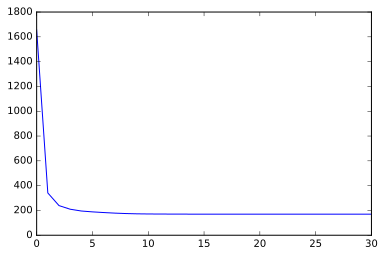

In [20]:
#  Look at a larger, random data set.
#  Watch what happens to energy as the iterations proceed.
#
n = 10000
k = 10
xy = np.random.random ( [ n, 2 ] )
c = initial_clusters_random ( n, k )
ivec = []
evec = []
for i in range ( 0, 100 ):
  pop, mn, e = cluster_stats ( n, xy, c, k )
  ivec.append ( i )
  evec.append ( sum ( e ) )
  c, swaps = move_data ( n, xy, c, k, mn )
  if ( swaps == 0 ):
    print ( 'No point swaps!')
    break
    
plt.plot ( ivec, evec )

